# Lab 3: PCA Reconstruction Error & Gradient Descent Variants

**Datasets:** `advertising.csv`, `faa.csv`, `Housing.csv`

This notebook computes PCA reconstruction errors (following the Eigenfaces/PCA method) and compares Simple GD vs Momentum GD vs Nesterov (NAG) on linear regression tasks.

Place the CSV files in the same folder as this notebook and run the cells sequentially.

## 1. Imports and plotting setup

In [12]:
# Cell 1: imports and utility functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (8,5)


## 2. Robust data loading / cleaning utilities
- Keep numeric columns
- Replace inf with NaN
- Drop columns that are completely NaN
- Fill remaining NaNs with column mean


In [5]:

def clean_and_load(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found in working directory.")
    df = pd.read_csv(filename)
    # Keep only numeric columns
    df_num = df.select_dtypes(include=[np.number]).copy()
    # Replace inf / -inf with NaN
    df_num = df_num.replace([np.inf, -np.inf], np.nan)
    # Drop columns with all NaN values
    df_num = df_num.dropna(axis=1, how='all')
    # Fill remaining NaNs with column mean
    for col in df_num.columns:
        if df_num[col].isnull().any():
            mean_val = df_num[col].mean()
            if np.isnan(mean_val):
                df_num = df_num.drop(columns=[col])
            else:
                df_num[col] = df_num[col].fillna(mean_val)
    df_num = df_num.dropna(axis=0, how='all')
    return df_num


## 3. PCA reconstruction error implementation

In [6]:

def pca_reconstruction_errors(X, n_list=[1,2,3,5,7,10,15]):
    n_samples, n_features = X.shape
    mu = X.mean(axis=0, keepdims=True)
    A = X - mu
    if np.isnan(A).any() or np.isinf(A).any():
        raise ValueError('A contains NaN or Inf after cleaning.')
    M = A.T @ A
    vals, vecs = eig(M)
    vals = np.real(vals); vecs = np.real(vecs)
    idx = np.argsort(vals)[::-1]
    vals = vals[idx]; vecs = vecs[:, idx]
    results = {}
    for n in n_list:
        if n > n_features:
            results[n] = None
            continue
        U = vecs[:, :n]
        norms = np.linalg.norm(U, axis=0, keepdims=True)
        norms[norms == 0] = 1.0
        U = U / norms
        W = A @ U
        A_recon = W @ U.T
        X_recon = A_recon + mu
        err = np.sum((X - X_recon)**2)
        results[n] = float(err)
    return results


## 4. Run PCA errors on datasets

In [7]:

filenames = ['advertising.csv','faa.csv','Housing.csv']
n_list = [1,2,3,5,7,10,15]
all_results = {}
for fname in filenames:
    print(f"Processing {fname} ...")
    try:
        df = clean_and_load(fname)
    except Exception as e:
        print('  Error loading:', e); continue
    if df.shape[1] < 2:
        print('  Not enough numeric columns. Skipping.'); continue
    X = df.iloc[:, :-1].values.astype(float)
    print('  Data shape (samples x features):', X.shape)
    print('  NaNs/Infs in X:', np.isnan(X).sum(), np.isinf(X).sum())
    try:
        results = pca_reconstruction_errors(X, n_list)
    except Exception as e:
        print('  PCA error:', e); results = {n: None for n in n_list}
    all_results[fname] = results
    print('  Reconstruction errors (sum squared):')
    for n, err in results.items():
        print(f'    n={n:2d} -> {err}')


Processing advertising.csv ...
  Data shape (samples x features): (200, 3)
  NaNs/Infs in X: 0 0
  Reconstruction errors (sum squared):
    n= 1 -> 137786.12440737645
    n= 2 -> 35086.87584251772
    n= 3 -> 1.3214123357993242e-25
    n= 5 -> None
    n= 7 -> None
    n=10 -> None
    n=15 -> None
Processing faa.csv ...
  Data shape (samples x features): (83, 10)
  NaNs/Infs in X: 0 0
  Reconstruction errors (sum squared):
    n= 1 -> 27.783878914671064
    n= 2 -> 3.32031061225999
    n= 3 -> 1.3203106122599895
    n= 5 -> 5.1152699322924984e-30
    n= 7 -> 5.1152699322924984e-30
    n=10 -> 5.1152699322924984e-30
    n=15 -> None
Processing Housing.csv ...
  Data shape (samples x features): (545, 5)
  NaNs/Infs in X: 0 0
  Reconstruction errors (sum squared):
    n= 1 -> 1825936793.8215957
    n= 2 -> 680.3408794841131
    n= 3 -> 292.339937153406
    n= 5 -> 2.6237768469268356e-17
    n= 7 -> None
    n=10 -> None
    n=15 -> None


## 5. Plot PCA errors (if available)

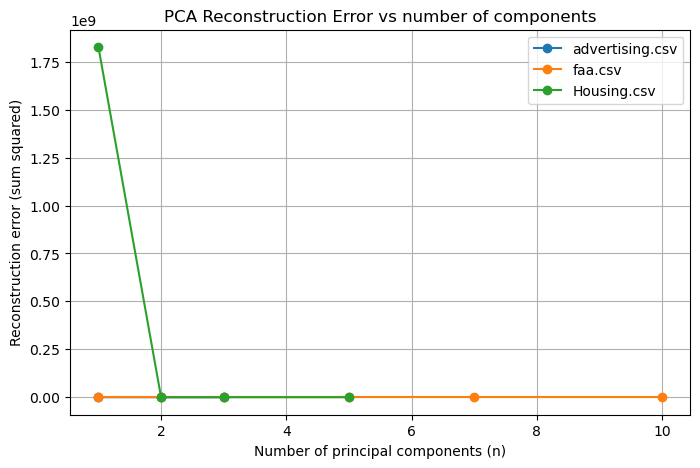

In [8]:

import matplotlib.pyplot as plt
for fname, results in all_results.items():
    ns = []; errs = []
    for n in sorted(results.keys()):
        if results[n] is None: continue
        ns.append(n); errs.append(results[n])
    if ns:
        plt.plot(ns, errs, marker='o', label=fname)
plt.xlabel('Number of principal components (n)')
plt.ylabel('Reconstruction error (sum squared)')
plt.title('PCA Reconstruction Error vs number of components')
plt.legend(); plt.grid(True); plt.show()


## 6. Gradient Descent variants for Linear Regression

In [9]:

def mse_loss(X, y, w):
    preds = X @ w; err = preds - y; return 0.5 * np.mean(err**2)

def grad_mse(X, y, w):
    n = X.shape[0]; return (X.T @ (X @ w - y)) / n

def run_simple_gd(X, y, lr=0.01, n_iters=1000):
    w = np.zeros(X.shape[1]); losses = []
    for i in range(n_iters):
        g = grad_mse(X, y, w); w = w - lr * g; losses.append(mse_loss(X, y, w))
    return w, losses

def run_momentum_gd(X, y, lr=0.01, gamma=0.9, n_iters=1000):
    w = np.zeros(X.shape[1]); v = np.zeros_like(w); losses = []
    for i in range(n_iters):
        g = grad_mse(X, y, w); v = gamma * v + lr * g; w = w - v; losses.append(mse_loss(X, y, w))
    return w, losses

def run_nesterov_gd(X, y, lr=0.01, gamma=0.9, n_iters=1000):
    w = np.zeros(X.shape[1]); v = np.zeros_like(w); losses = []
    for i in range(n_iters):
        w_look = w - gamma * v; g = grad_mse(X, y, w_look); v = gamma * v + lr * g; w = w - v; losses.append(mse_loss(X, y, w))
    return w, losses


## 7. Run GD comparisons on each dataset

In [10]:

gd_results = {}
for fname in filenames:
    print(f'\nRunning GD on {fname} ...')
    try:
        df = clean_and_load(fname)
    except Exception as e:
        print('  Error loading:', e); continue
    if df.shape[1] < 2:
        print('  Not enough numeric columns. Skipping.'); continue
    X_raw = df.iloc[:, :-1].values.astype(float); y_raw = df.iloc[:, -1].values.astype(float)
    scaler = StandardScaler(); X_std = scaler.fit_transform(X_raw)
    X = np.hstack([X_std, np.ones((X_std.shape[0],1))]); y = y_raw.copy()
    print('  X shape (with bias):', X.shape)
    lr = 0.05; gamma = 0.9; n_iters = 500
    w_s, losses_s = run_simple_gd(X, y, lr=lr, n_iters=n_iters)
    w_m, losses_m = run_momentum_gd(X, y, lr=lr, gamma=gamma, n_iters=n_iters)
    w_n, losses_n = run_nesterov_gd(X, y, lr=lr, gamma=gamma, n_iters=n_iters)
    gd_results[fname] = {'simple': losses_s, 'momentum': losses_m, 'nesterov': losses_n}
    print(f'  Final losses -> simple: {losses_s[-1]:.6f}, momentum: {losses_m[-1]:.6f}, nesterov: {losses_n[-1]:.6f}')



Running GD on advertising.csv ...
  X shape (with bias): (200, 4)
  Final losses -> simple: 1.353003, momentum: 1.353003, nesterov: 1.353003

Running GD on faa.csv ...
  X shape (with bias): (83, 11)
  Final losses -> simple: 0.000000, momentum: 0.000000, nesterov: 0.000000

Running GD on Housing.csv ...
  X shape (with bias): (545, 6)
  Final losses -> simple: 0.300431, momentum: 0.300431, nesterov: 0.300431


## 8. Plot GD convergence curves

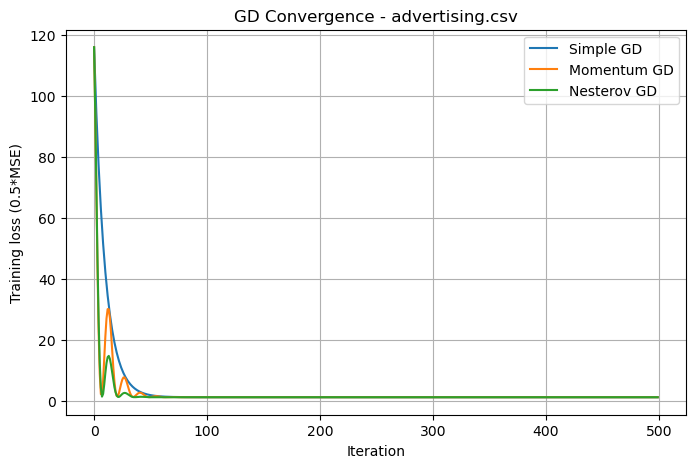

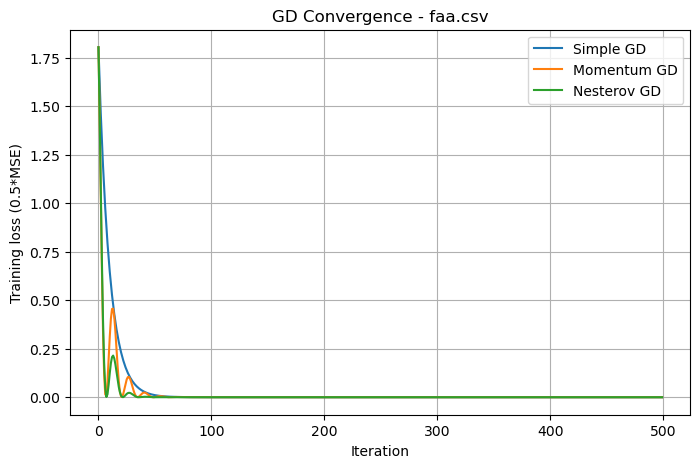

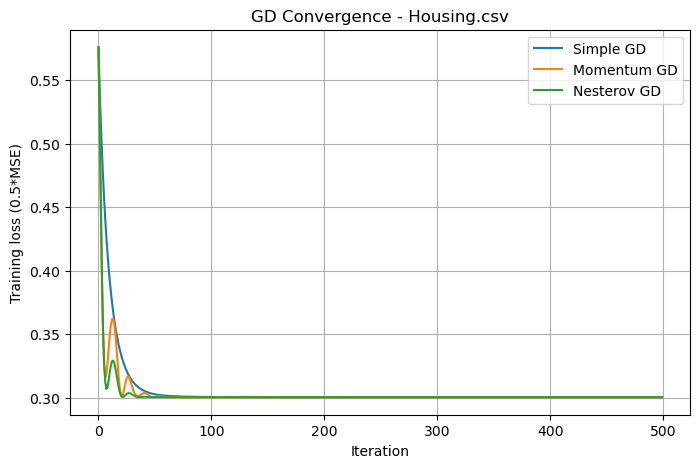

In [11]:

for fname, curves in gd_results.items():
    plt.figure()
    plt.plot(curves['simple'], label='Simple GD')
    plt.plot(curves['momentum'], label='Momentum GD')
    plt.plot(curves['nesterov'], label='Nesterov GD')
    plt.xlabel('Iteration'); plt.ylabel('Training loss (0.5*MSE)')
    plt.title(f'GD Convergence - {fname}'); plt.legend(); plt.grid(True); plt.show()


## Save this notebook
The notebook is saved at `/mnt/data/Lab3_Complete_Lab3.ipynb`. Run it locally to execute and produce outputs.